In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from numba import cuda
import pandas as pd

In [2]:
#Функция для поиска на CPU
def mass_search_CPU(R, N, H):
    for j in range(R.shape[1]):
        for i in range(R.shape[0]):
            n = N[i]
            for k in range(len(n)):
                if j - k >= 0 and n[k] == H[j]:
                    R[i, j - k] -= 1
    return R

#Функция для поиска на GPU
@cuda.jit
def mass_search_GPU(R, N, H):
    i, j = cuda.grid(2)
    if i < R.shape[0] and j < R.shape[1]:
        n = N[i]
        for k in range(len(n)):
            if j - k >= 0 and n[k] == H[j]:
                R[i, j - k] -= 1

def start_calculation(sizes):
    table_values_CPU = []
    table_values_GPU = []

    for size in sizes:
        CPU_times = []
        GPU_times = []

        for _ in range(10):
            N = np.random.randint(256, size=(size, 3), dtype=np.uint8)
            H = np.random.randint(256, size=size, dtype=np.uint8)
            R = np.zeros((size, size), dtype=int)

            start_CPU = time.time()
            mass_search_CPU(R.copy(), N, H)
            end_CPU = time.time()
            CPU_times.append(end_CPU - start_CPU)

            R_GPU = cuda.to_device(R.copy())
            N_GPU = cuda.to_device(N)
            H_GPU = cuda.to_device(H)

            start_GPU = time.time()
            mass_search_GPU[blocks_per_grid, threads_per_block](R_GPU, N_GPU, H_GPU)
            cuda.synchronize()
            end_GPU = time.time()
            GPU_times.append(end_GPU - start_GPU)

        table_values_CPU.append(np.mean(CPU_times))
        table_values_GPU.append(np.mean(GPU_times))

    return np.array(table_values_CPU), np.array(table_values_GPU)

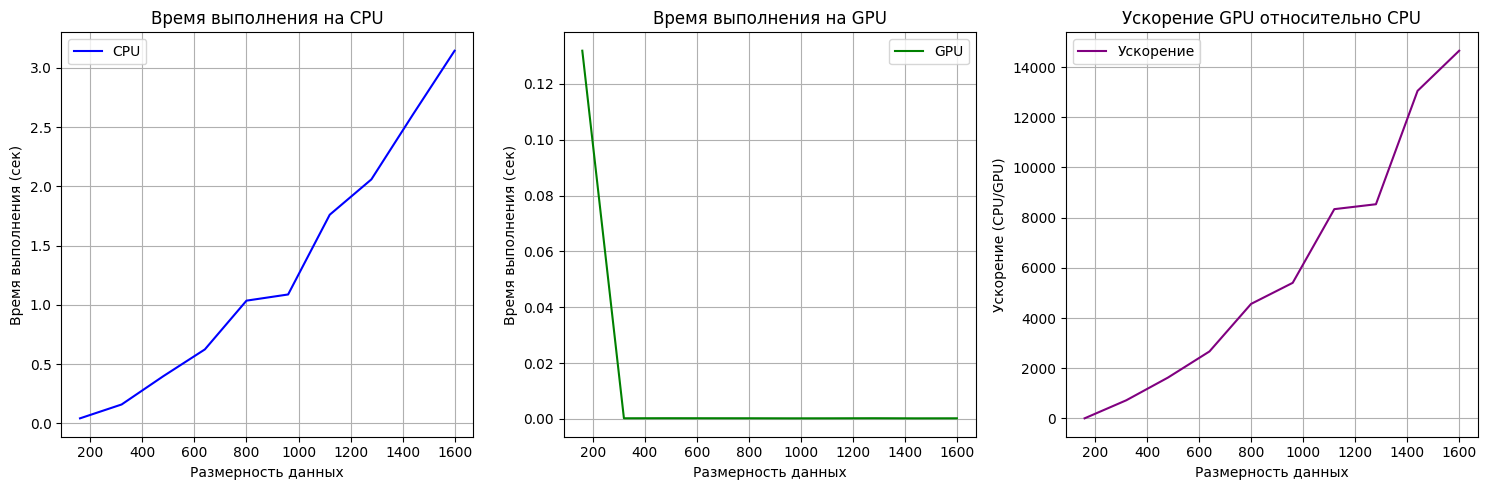


Результаты выполнения:

   Размер данных  Время на CPU (среднее)  Время на GPU (среднее)  \
0            160                0.042810                0.131877   
1            320                0.159811                0.000222   
2            480                0.398133                0.000245   
3            640                0.624485                0.000234   
4            800                1.035879                0.000227   
5            960                1.087986                0.000201   
6           1120                1.760819                0.000211   
7           1280                2.058741                0.000241   
8           1440                2.606954                0.000200   
9           1600                3.144662                0.000215   

   Ускорение (CPU/GPU)  
0             0.324620  
1           718.891034  
2          1622.355290  
3          2666.746793  
4          4561.939521  
5          5402.326980  
6          8339.443654  
7          8535.126619  
8

In [3]:
threads_per_block = (8, 8)
blocks_per_grid = (16, 16)

sizes = np.linspace(160, 1600, 10, dtype=int)

mas_CPU_time, mas_GPU_time = start_calculation(sizes)

speedup = mas_CPU_time / mas_GPU_time

plt.figure(figsize=(15, 5))

#Время выполнения на CPU
plt.subplot(1, 3, 1)
plt.plot(sizes, mas_CPU_time, label="CPU", color="blue")
plt.xlabel("Размерность данных")
plt.ylabel("Время выполнения (сек)")
plt.title("Время выполнения на CPU")
plt.grid()
plt.legend()

#Время выполнения на GPU
plt.subplot(1, 3, 2)
plt.plot(sizes, mas_GPU_time, label="GPU", color="green")
plt.xlabel("Размерность данных")
plt.ylabel("Время выполнения (сек)")
plt.title("Время выполнения на GPU")
plt.grid()
plt.legend()

#Ускорение
plt.subplot(1, 3, 3)
plt.plot(sizes, speedup, label="Ускорение", color="purple")
plt.xlabel("Размерность данных")
plt.ylabel("Ускорение (CPU/GPU)")
plt.title("Ускорение GPU относительно CPU")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    "Размер данных": sizes,
    "Время на CPU (среднее)": mas_CPU_time,
    "Время на GPU (среднее)": mas_GPU_time,
    "Ускорение (CPU/GPU)": speedup
})

print("\nРезультаты выполнения:\n")
print(results_df)